In [1]:
import numpy as np
from numpy import asarray
from numpy import save
from numpy import load

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.layers import Add, ReLU, Dense
from tensorflow.keras import Model
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import glob
import random

In [3]:
# Loading data
X_train = load('/content/drive/MyDrive/data/X_train.npy')
Y_train = load('/content/drive/MyDrive/data/Y_train.npy')

In [6]:
print(X_train.shape,Y_train.shape)
print(X_train[a].shape)

(500, 256, 256, 3) (500, 10)
(256, 256, 3)


[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


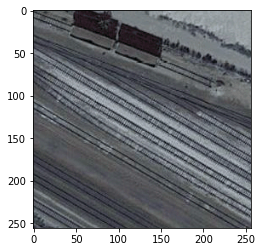

In [5]:
a =310
plt.imshow(X_train[a]/255)
print(Y_train[a])

In [7]:
#Conv-BatchNorm-ReLU block

def conv_layer(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    return x

In [8]:
#Identity block

def res_identity(tensor, filters):
    
    x = conv_layer(tensor, filters=filters, kernel_size=1, strides=1)
    x = conv_layer(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
    x = BatchNormalization()(x)
    
    x = Add()([tensor,x])    #skip connection
    x = ReLU()(x)
    
    return x

In [9]:
#Projection block

def projection_block(tensor, filters, strides):
    
    #left stream
    x = conv_layer(tensor, filters=filters, kernel_size=1, strides=strides)
    x = conv_layer(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
    x = BatchNormalization()(x)
    
    #right stream
    shortcut = Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut,x])    #skip connection
    x = ReLU()(x)
    
    return x

In [10]:
#Resnet block

def resnet_block(x, filters, reps, strides):
    
    x = projection_block(x, filters, strides)
    for _ in range(reps-1):
        x = res_identity(x,filters)
        
    return x

In [26]:
def get_model(model_name):
  if model_name == "ResNet":
    inputs = keras.Input(shape=(256, 256, 3), name="img")
    x = conv_layer(inputs, filters=64, kernel_size=7, strides=2)
    x = MaxPool2D(pool_size = 3, strides =2)(x)
    x = resnet_block(x, filters=32, reps =3, strides=1)
    x = resnet_block(x, filters=64, reps =2, strides=2)
    x = resnet_block(x, filters=128, reps =3, strides=2)
    x = resnet_block(x, filters=256, reps =3, strides=2)
    x = GlobalAvgPool2D()(x)
    x = Dense(256,activation='relu')(x)
    outputs = Dense(10, activation ='softmax')(x)

    model = keras.Model(inputs, outputs, name="Resnet")
    model.summary()
    return model

  elif model_name == 'VGG':
    inputs = tf.keras.layers.Input((256, 256, 3))
    x = layers.Conv2D(32, 3, activation='relu', padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(10,activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="VGG")

    model.summary()
    return model

  elif model_name == "VGG2":
    inputs = keras.Input(shape=(256, 256, 3), name="img")
    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D(3)(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(3)(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)

    x = layers.Conv2D(128, 3, activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10,activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="Mini_VGGNet")
    model.summary()
    return model
  """elif model_name == "Inception v2":
  elif model_name == "Inception v3": 
  elif model_name == "Inception v4":  
  elif model_name == "DenseNet":
  elif model_name == "MobileNet":"""
  


In [27]:
model_name = "VGG2"
model = get_model(model_name)
fig_name = model_name +".png"
#keras.utils.plot_model(model, fig_name, show_shapes=True)

Model: "Mini_VGGNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 252, 252, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 84, 84, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 84, 84, 64)        36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 84, 84, 64)        36928     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 84, 84, 64)        

In [4]:
model = tf.keras.models.load_model('/content/drive/MyDrive/GNR model/Resnet_v2')

In [ ]:
model.summary()

In [17]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(
    loss='categorical_crossentropy', 
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["accuracy"],
)

In [18]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=50, validation_split=0.2, shuffle=True)

Epoch 1/50
7/7 [==============================] - 50s 7s/step - loss: 40.3185 - accuracy: 0.1350 - val_loss: 5.0313 - val_accuracy: 0.0000e+00
Epoch 2/50
7/7 [==============================] - 46s 7s/step - loss: 2.1660 - accuracy: 0.1625 - val_loss: 3.7946 - val_accuracy: 0.0000e+00
Epoch 3/50
7/7 [==============================] - 46s 7s/step - loss: 2.1579 - accuracy: 0.1625 - val_loss: 4.5475 - val_accuracy: 0.0000e+00
Epoch 4/50
7/7 [==============================] - 46s 7s/step - loss: 2.0306 - accuracy: 0.1950 - val_loss: 8.0352 - val_accuracy: 0.0000e+00
Epoch 5/50
7/7 [==============================] - 46s 7s/step - loss: 1.9858 - accuracy: 0.2400 - val_loss: 7.2245 - val_accuracy: 0.0000e+00
Epoch 6/50
7/7 [==============================] - 47s 7s/step - loss: 1.8197 - accuracy: 0.3225 - val_loss: 9.1788 - val_accuracy: 0.0000e+00
Epoch 7/50
7/7 [==============================] - 46s 6s/step - loss: 1.5936 - accuracy: 0.4200 - val_loss: 13.9312 - val_accuracy: 0.0000e+00
Epoc

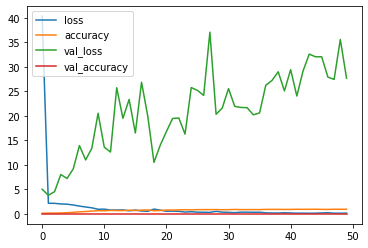

In [19]:
#plotting the learning curve
import pandas as pd
pd.DataFrame(history.history).plot()

In [20]:
model.save('/content/drive/MyDrive/GNR model/VGG_v1_no_aug_no_batchnorm_50_epoch')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GNR model/VGG_v1_no_aug_no_batchnorm_50_epoch/assets


In [21]:
score = model.evaluate(X_train,Y_train,verbose=0)
print(score)

[5.567316055297852, 0.7940000295639038]


In [22]:
a =310
print(Y_train[a])
prediction = model.predict(X_train)
print(np.argmax(prediction[a])+1)

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
7


In [23]:
# prediction
images = [cv2.imread(file) for file in glob.glob("/content/drive/MyDrive/data/gnr_test/*.jpg")]
print("Shape of images: ",images[0].shape)
print("Number of images in class: ",len(images))
no_images = len(images)
images = np.array(images)
print(images.shape)

Shape of images:  (256, 256, 3)
Number of images in class:  100
(100, 256, 256, 3)


In [24]:
predictions = model.predict(images)
final_class_pred = []

for i in range(no_images):
  final_class_pred.append(np.argmax(predictions[i])+1)
print(len(final_class_pred))

100


In [25]:
#creating csv file
import csv
import pandas

f = open('/content/drive/MyDrive/GNR model/200050103.csv', 'w')
row = 'ImageID','LabelID'

# create the csv writer
writer = csv.writer(f)
writer.writerow(row)
for i in range(101,201):
  row = i,final_class_pred[i-101]
  # write a row to the csv file
  writer.writerow(row)

# close the file
f.close()